#NOTEBOOK FOR THE USE OF TRANSFORMERS WITH HIGH ACCURACY

##Need to have accounts in HuggingFaces and wandb.ai
####Ensure your runtime is set to GPU
1. Go to runtime on your Colab
2. Click on Change runtimetype
3. Select T4 GPU



## Fine-tune the Vision Transformer on Fashion Product Images


Pre-trained [Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit) ([Transformers](https://github.com/huggingface/transformers)) on the Fashion Product Images dataset.



In [1]:
#install the relevant libraries
!pip install -q transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Loading the data
Here we load Fashion Products, a famous fashion image dataset, from HuggingFace's [hub](https://huggingface.co/datasets/ceyda/fashion-products-small). Note that you can view all examples of the dataset directly in your browser!
We shall be working with **Fashion Product Images Dataset** from a python library called datasets
For demonstration purposes, we will only actually use a small portion.

In [29]:
from datasets import load_dataset

data1 = load_dataset('ceyda/fashion-products-small')
data2 = data1

Repo card metadata block was not found. Setting CardData to empty.


In [30]:
# Split the dataset into train and validation (e.g., 80% train, 20% validation)
train_val_split = data1['train'].train_test_split(test_size=0.2, seed=42)

# Access the new splits
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

# Optional: Create a separate test split from the original data (e.g., 10% of total)
test_split = train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = test_split['train']
test_dataset = test_split['test']

# Print the sizes of the splits
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Train dataset: 30744 samples
Validation dataset: 8540 samples
Test dataset: 3416 samples


###This dataset is too big and will take a lot of time to train so we are taking only 25% for it for this practice session


In [56]:
from datasets import load_dataset

# Load the dataset
data = load_dataset('ceyda/fashion-products-small')

# Step 1: Split into 60% (extra) and 40% (train + valid + test)
extra_split = data['train'].train_test_split(test_size=0.4, seed=42)
extra_ds = extra_split['train']
remaining_ds = extra_split['test']

# Step 2: Split the remaining 40% into 50% (train) and 50% (valid + test)
train_valid_test_split = remaining_ds.train_test_split(test_size=0.5, seed=42)
train_ds = train_valid_test_split['train']
valid_test_ds = train_valid_test_split['test']

# Step 3: Split the remaining valid_test_ds into 50% (valid) and 50% (test)
valid_test_split = valid_test_ds.train_test_split(test_size=0.5, seed=42)
valid_ds = valid_test_split['train']
test_ds = valid_test_split['test']

# Print the sizes of the splits
print(f"Extra dataset: {len(extra_ds)} samples (60%)")
print(f"Train dataset: {len(train_ds)} samples (20%)")
print(f"Validation dataset: {len(valid_ds)} samples (10%)")
print(f"Test dataset: {len(test_ds)} samples (10%)")


Repo card metadata block was not found. Setting CardData to empty.


Extra dataset: 25620 samples (60%)
Train dataset: 8540 samples (20%)
Validation dataset: 4270 samples (10%)
Test dataset: 4270 samples (10%)


In [58]:
# Extract the 'train' and 'test' data
train_data = train_ds
valid_data = valid_ds
test_data = test_ds

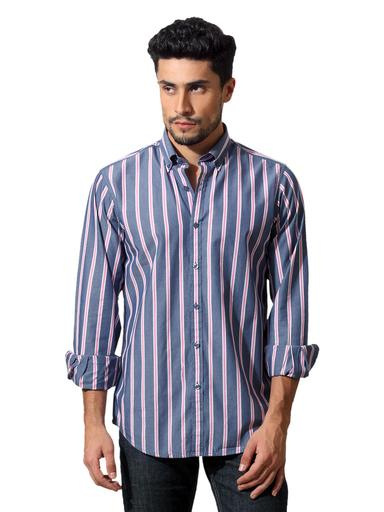

In [59]:
train_data[200]['image']

Of course, we would like to know the actual class name, rather than the

---

integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [60]:
label = list(set(train_data['masterCategory']))
id2label = {id:label for id, label in enumerate(label)}
label2id = {label:id for id,label in id2label.items()}
print(id2label, label2id)

{0: 'Free Items', 1: 'Personal Care', 2: 'Accessories', 3: 'Footwear', 4: 'Apparel', 5: 'Sporting Goods'} {'Free Items': 0, 'Personal Care': 1, 'Accessories': 2, 'Footwear': 3, 'Apparel': 4, 'Sporting Goods': 5}


## Preprocessing the data

We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`.

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

In [35]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [37]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            # CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [38]:
# Set the transforms
train_data.set_transform(train_transforms)
# val_ds.set_transform(val_transforms)
test_data.set_transform(val_transforms)

It's very easy to create a corresponding PyTorch DataLoader, like so:

In [39]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["masterCategory"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_data, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

In [40]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [41]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


However, we'll not be using dataloaders, as we are going to use HuggingFace's Trainer API.

## Define the model

Here we define the model. We define a `ViTForImageClassification`, which places a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) on top of a pre-trained `ViTModel`. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image.

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. You can find all info of the model we are going to use [here](https://huggingface.co/google/vit-base-patch16-224-in21k).

We also specify the number of output neurons by setting the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as `model.config`).

In [42]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
model.to(torch.device("cuda"))


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

To instantiate a `Trainer`, we will need to define three more things. The most important is the `TrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

We also set the argument "remove_unused_columns" to False, because otherwise the "img" column would be removed, which is required for the data transformations.

In [44]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    "Fashion-Product-Images",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #0.00002
    per_device_train_batch_size=32,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, set the training and evaluation batch_sizes and customize the number of epochs for training, as well as the weight decay.

We also define a `compute_metrics` function that will be used to compute metrics at evaluation. We use "accuracy" here.


In [45]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [46]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-46-51bf7d67e415>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train the model

Let's first start up Tensorboard:

In [47]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [48]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.155510,0.987822
2,0.299400,0.112703,0.989696
3,0.299400,0.103958,0.989930


TrainOutput(global_step=801, training_loss=0.22639410564217824, metrics={'train_runtime': 1261.5112, 'train_samples_per_second': 20.309, 'train_steps_per_second': 0.635, 'total_flos': 1.9854159499948032e+18, 'train_loss': 0.22639410564217824, 'epoch': 3.0})

## Evaluation

Finally, let's evaluate the model on the test set:

In [49]:
outputs = trainer.predict(test_data)

In [50]:
print(outputs.metrics)

{'test_loss': 0.10395848006010056, 'test_accuracy': 0.9899297423887587, 'test_runtime': 62.3172, 'test_samples_per_second': 68.52, 'test_steps_per_second': 17.138}


In [51]:
# Save the model's state dict
torch.save(model.state_dict(), 'vision_transformer_model.pth')


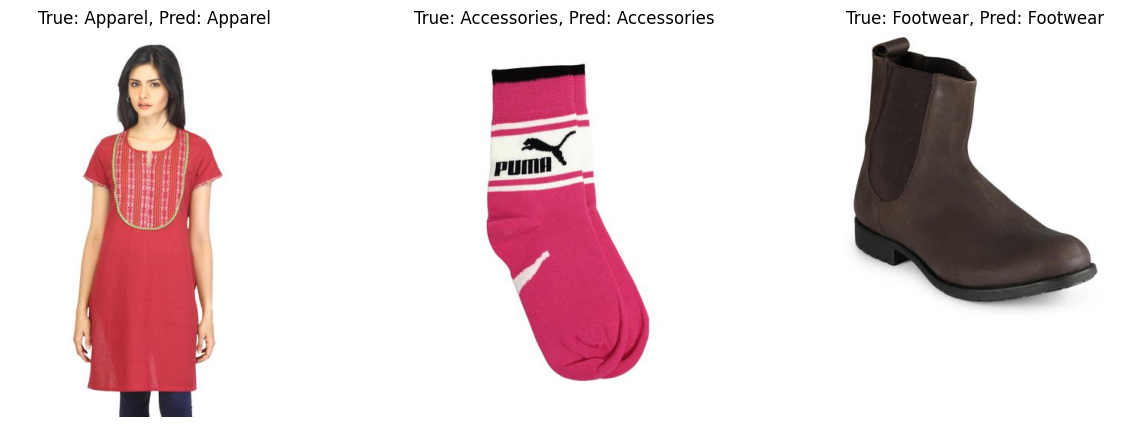

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Define id2label and label2id mappings based on your data
id2label = {0: 'Free Items', 1: 'Personal Care', 2: 'Accessories', 3: 'Footwear', 4: 'Apparel', 5: 'Sporting Goods'}
label2id = {'Free Items': 0, 'Personal Care': 1, 'Accessories': 2, 'Footwear': 3, 'Apparel': 4, 'Sporting Goods': 5}


# Run predictions on the test data
#outputs = trainer.predict(test_data)

# Extract the predictions (logits) and convert them to labels
predictions = np.argmax(outputs.predictions, axis=1)

# Display some images with their predicted labels
num_images = 3  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    # Get image and label
    img = test_data[i]['image']  # Assuming 'image' is the key containing the image
    img_label = test_data[i]['masterCategory']  # Ground truth label (if available)
    pred_label_idx = predictions[i]  # Predicted label (index)
    pred_label = id2label.get(pred_label_idx, "Unknown")  # Map the index to label

    # If the image is a tensor, convert it to numpy array
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Change the shape from (C, H, W) to (H, W, C)

    # Convert from float32 to uint8
    img = np.clip(img, 0, 255).astype('uint8')

    # Convert the numpy array to a PIL Image
    img = Image.fromarray(img)

    # Show the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"True: {img_label}, Pred: {pred_label}")  # Display true and predicted label


plt.show()
